In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
import re
from copy import deepcopy
from sklearn.decomposition import PCA
from numpy import savetxt, loadtxt
from scipy.stats import ranksums,mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
import graphviz
from scipy.stats import rankdata,spearmanr,pearsonr
from sklearn.linear_model import LogisticRegression
from scipy.special import logit
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from matplotlib import style
import seaborn as sns
from matplotlib_venn import venn2,venn3

In [52]:
from funcs import *

In [53]:
############################## Load all ate tables #################################################

In [54]:
ipw_ate_table = pd.read_csv(ipw_file, index_col=0)

ps_matching_ate_table_11 = pd.read_csv(ps_matching_ate_table_11_file, index_col=0)
ps_matching_ate_table_1n = pd.read_csv(ps_matching_ate_table_1n_file, index_col=0)

cov_matching_ate_table_11 = pd.read_csv(cov_matching_ate_table_11_file, index_col=0)
cov_matching_ate_table_1n = pd.read_csv(cov_matching_ate_table_1n_file, index_col=0)

genetic_sensitivity_ate_table = pd.read_csv(genetic_ate_table_file, index_col=0)

ps_matching_sensitivity_ate_table_11 = pd.read_csv(ps_sensitivity_ate_table_file, index_col=0)

cov_matching_sensitivity_ate_table_11 = pd.read_csv(cov_sensitivity_ate_table_file, index_col=0)

In [55]:
########### Evaluate the correlation between the different ATE computation methods ##########################

In [56]:
methods = ['IPW',
           'propensity score matching 1:1 (with replacement)',
           'propensity score matching 1:N (with replacement)',
           'covariate matching 1:1 (with replacement)',
           'covariate matching 1:N (with replacement)',
           'genetic matching (optimal, without replacement)']

ate_tables = [ipw_ate_table.sort_index(), 
              ps_matching_ate_table_11.sort_index(),
              ps_matching_ate_table_1n.sort_index(),
              cov_matching_ate_table_11.sort_index(),
              cov_matching_ate_table_1n.sort_index(),
              genetic_sensitivity_ate_table.sort_index()]

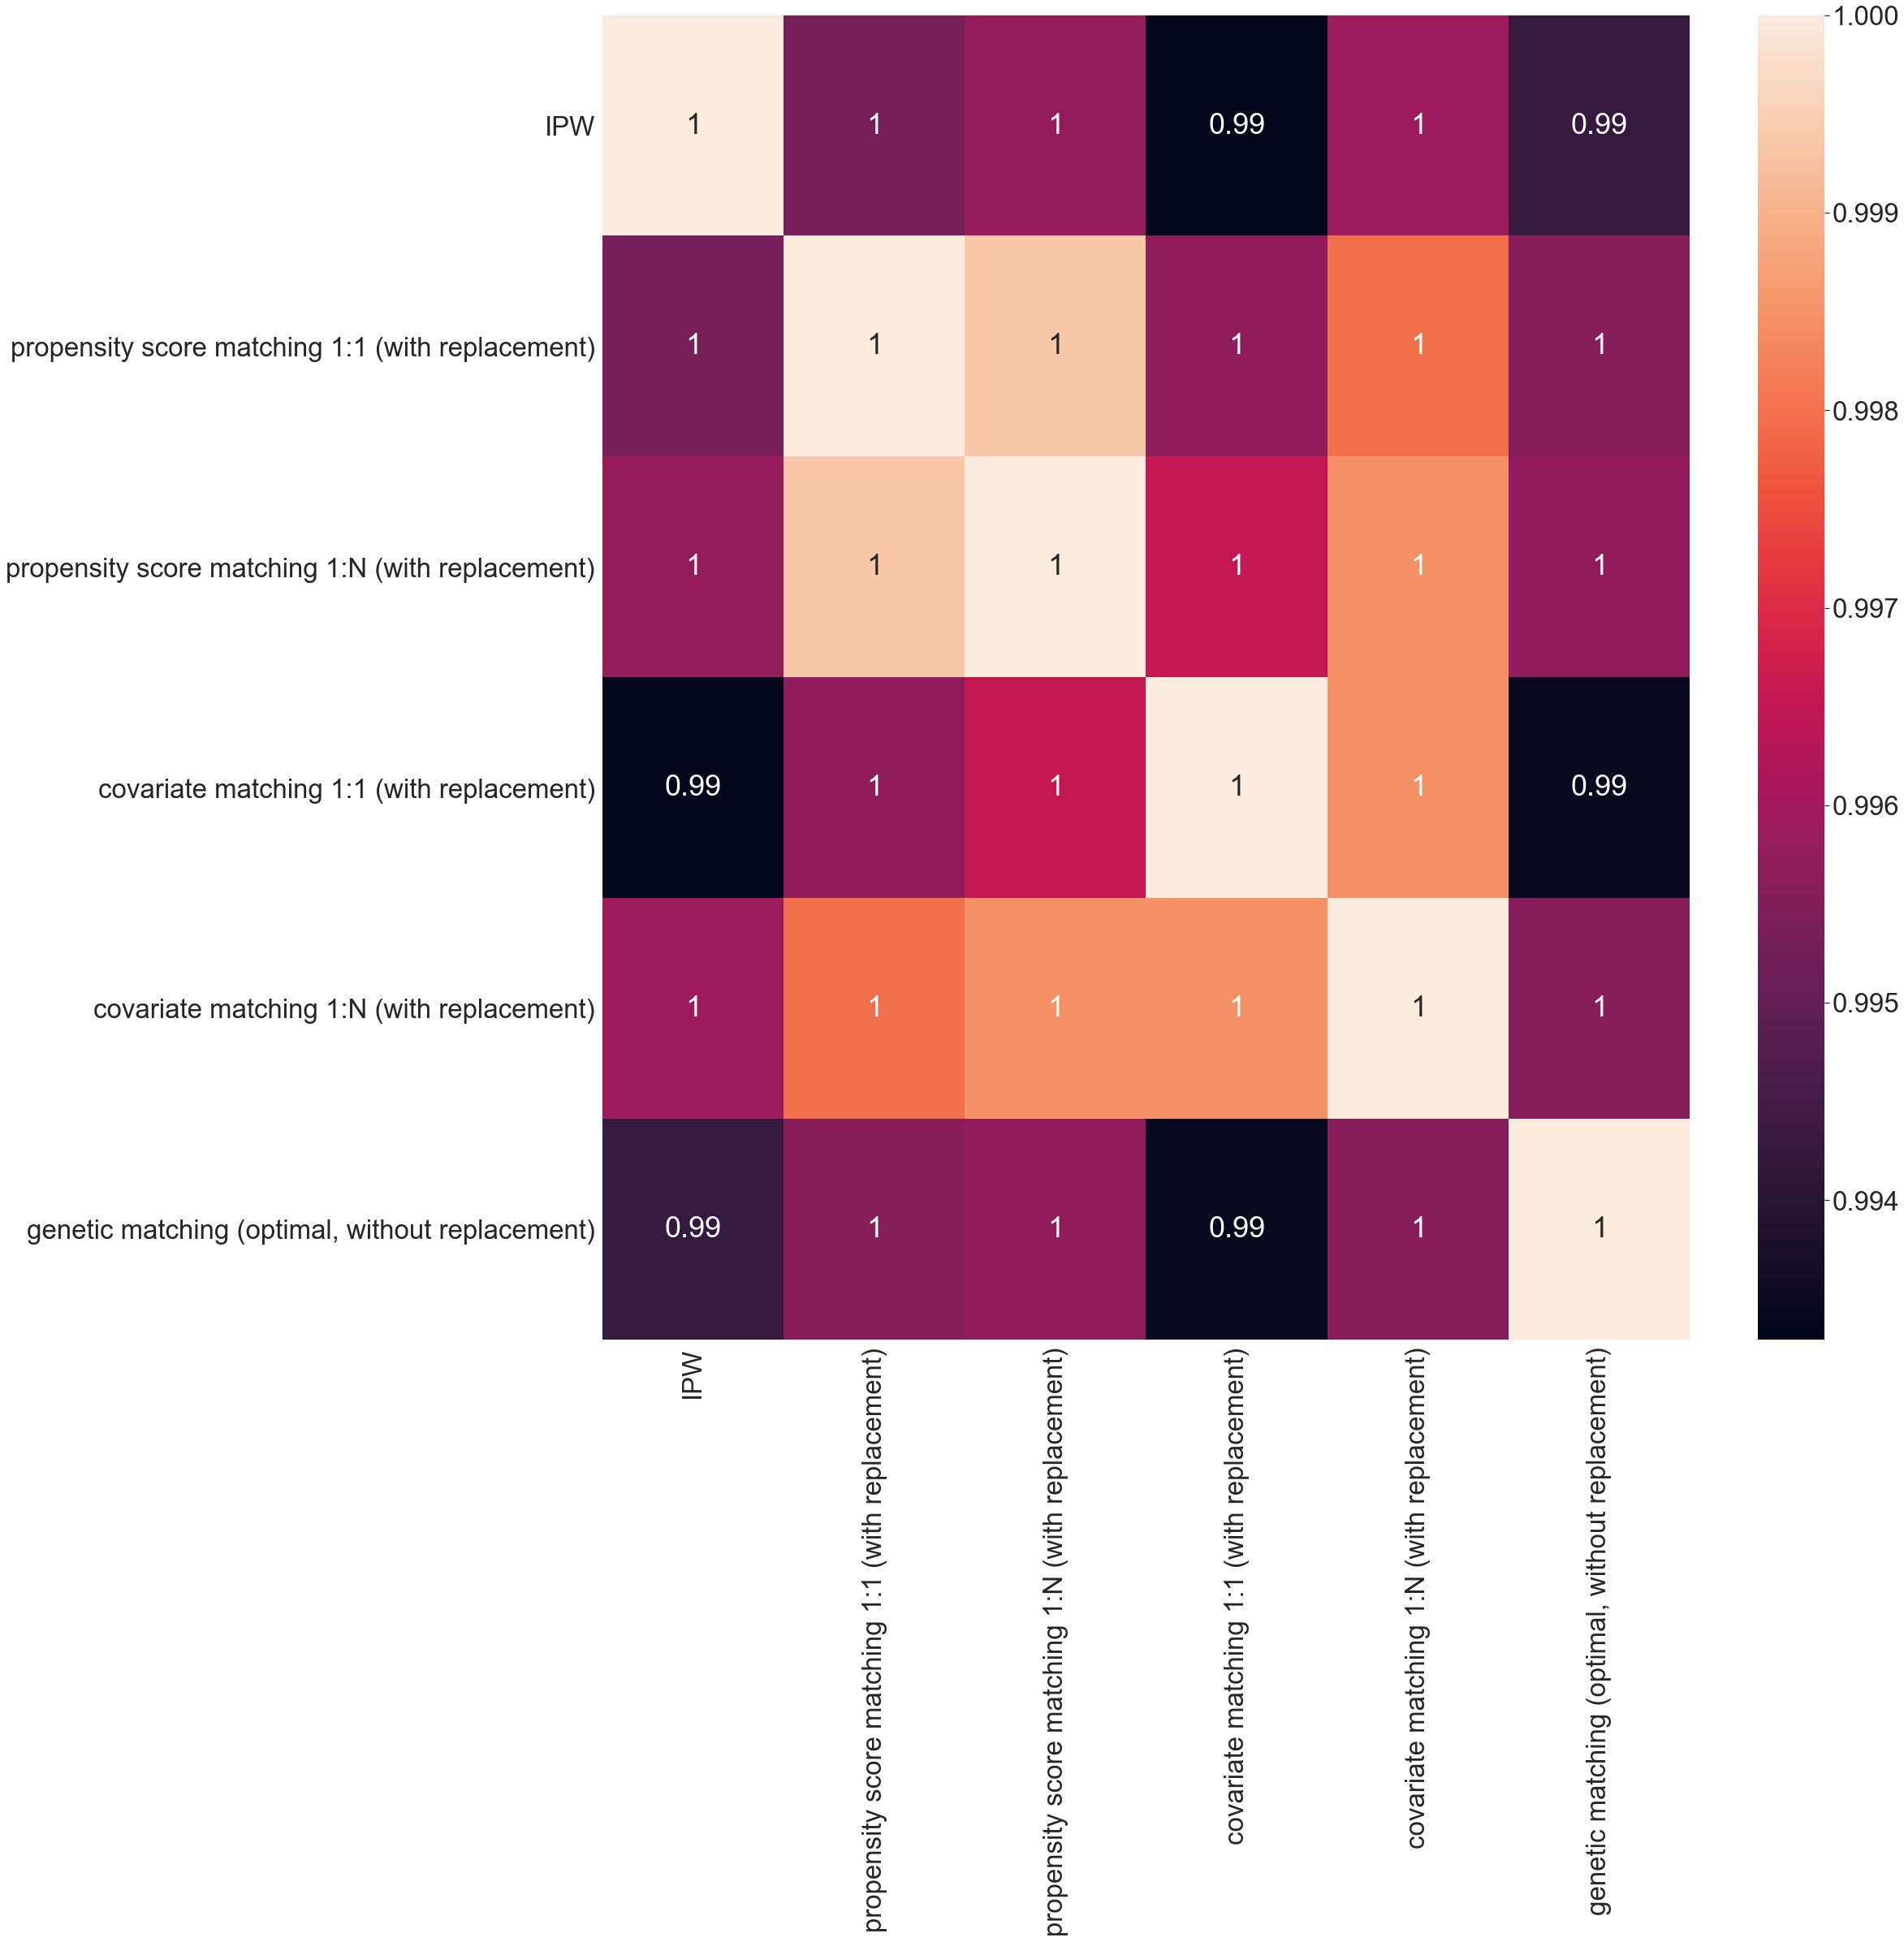

In [57]:
# spearman correlation
spearman_mat = np.ones((len(methods),len(methods)))
spearman_pvals = np.zeros((len(methods),len(methods)))

for i in range(len(methods)):
    for j in np.arange(i+1,len(methods)):
        spearman_mat[i,j],spearman_pvals[i,j] = spearmanr(
            ate_tables[i]['ate'],ate_tables[j]['ate'])
        spearman_mat[j,i],spearman_pvals[j,i] = spearman_mat[i,j],spearman_pvals[i,j]

plt.figure(figsize=(30,30))
sns.set(font_scale=3)
ax = sns.heatmap(spearman_mat, xticklabels=methods, yticklabels=methods, annot=True)

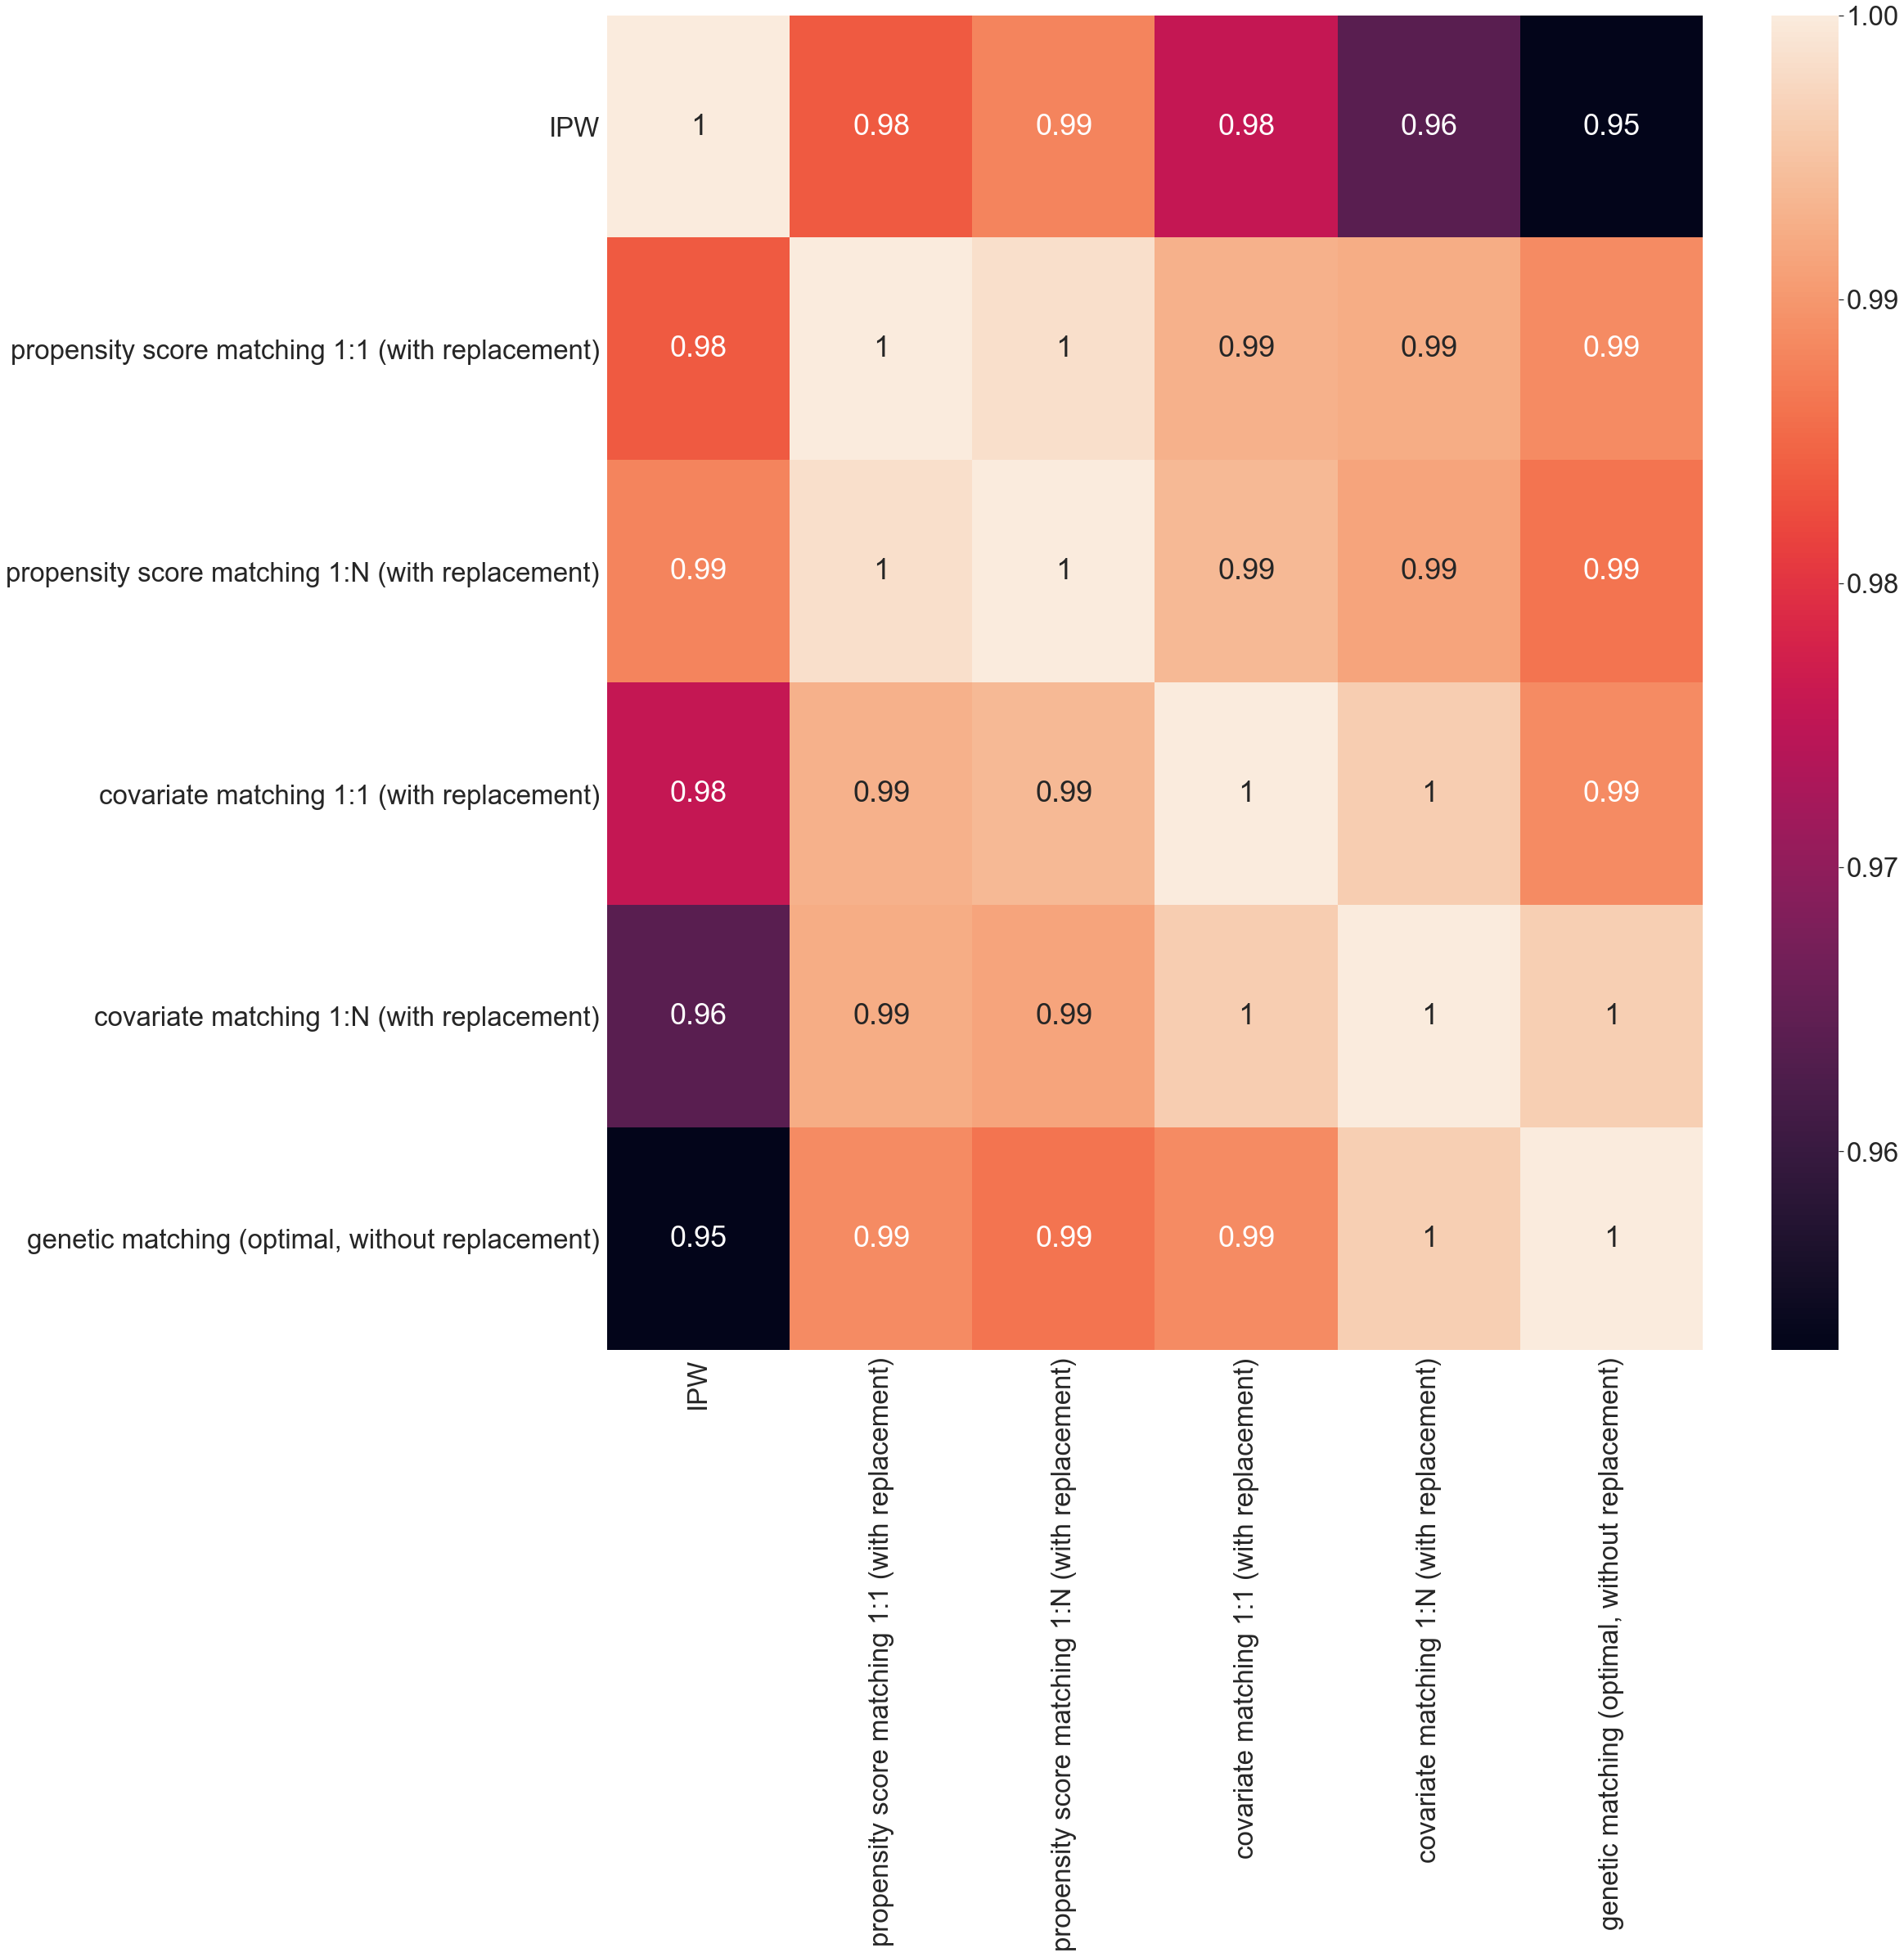

In [58]:
# pearson correlation
pearson_mat = np.ones((len(methods),len(methods)))
pearson_pvals = np.zeros((len(methods),len(methods)))

for i in range(len(methods)):
    for j in np.arange(i+1,len(methods)):
        pearson_mat[i,j],pearson_pvals[i,j] = pearsonr(
            ate_tables[i]['ate'],ate_tables[j]['ate'])
        pearson_mat[j,i],pearson_pvals[j,i] = pearson_mat[i,j],pearson_pvals[i,j]

plt.figure(figsize=(30,30))
sns.set(font_scale=3)
ax = sns.heatmap(pearson_mat, xticklabels=methods, yticklabels=methods, annot=True)

In [59]:
############### Compare confidence intervals between cootstrapping and sensitivity analysis ######################

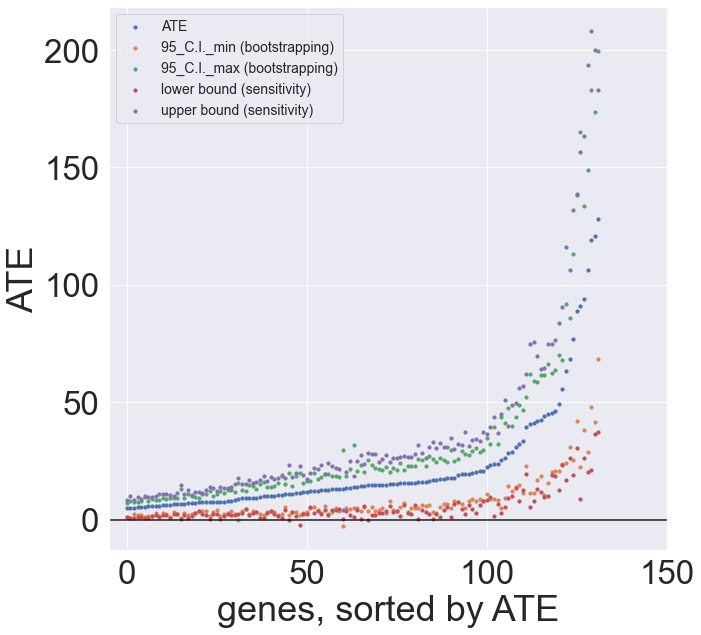

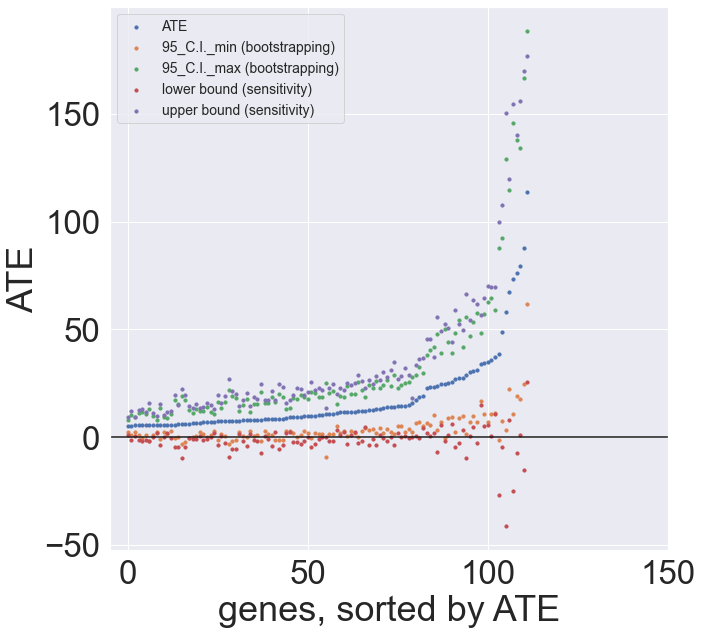

In [61]:
for table1,table2 in [[ps_matching_ate_table_11,ps_matching_sensitivity_ate_table_11],
                      [cov_matching_ate_table_11,cov_matching_sensitivity_ate_table_11]]:
    
    table1 = table1.sort_values(by='ate')    
    gene_inds = [x for x in table1.index if (table1.loc[x,'ate']>=5 and table1.loc[x,'ate']<=250)]

    plt.figure(figsize=(10,10))
    xaxis = range(len(gene_inds))
    plt.scatter(xaxis,table1.loc[gene_inds,'ate'], s=10, label='ATE')
    plt.scatter(xaxis,table1.loc[gene_inds,'95_C.I._min'], s=10, label='95_C.I._min (bootstrapping)')
    plt.scatter(xaxis,table1.loc[gene_inds,'95_C.I._max'], s=10, label='95_C.I._max (bootstrapping)')
    plt.scatter(xaxis,table2.loc[gene_inds,'lower_bound'], s=10, label='lower bound (sensitivity)')
    plt.scatter(xaxis,table2.loc[gene_inds,'upper_bound'], s=10, label='upper bound (sensitivity)')
    plt.xlabel('genes, sorted by ATE')
    plt.ylabel('ATE')
    plt.xlim(-5,150)
    plt.hlines(0,-5,200, colors='k')
    plt.legend(prop={'size': 14})

In [62]:
########################### Comparison of bootstrapping confidence intervals ##################################

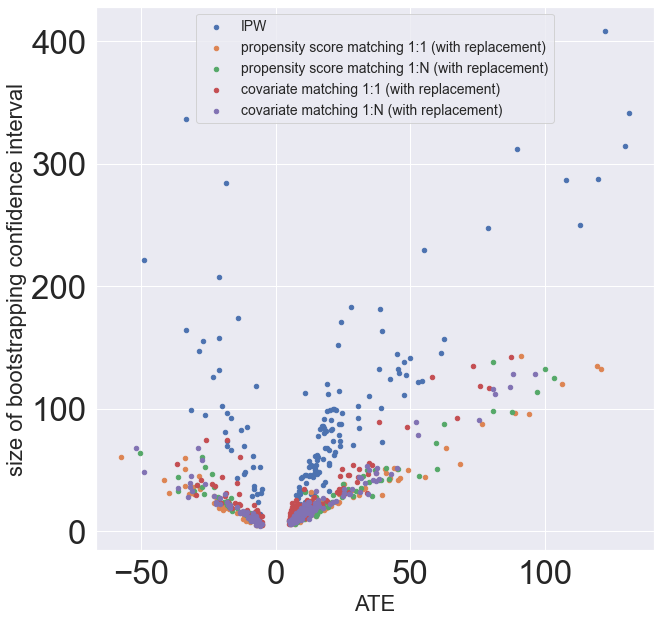

In [63]:
plt.figure(figsize=(10,10))
for table,method in zip(ate_tables[:5],methods[:5]):
    gene_inds = [x for x in table1.index if (np.abs(table1.loc[x,'ate'])>=5 and np.abs(table1.loc[x,'ate'])<=100)]
    plt.scatter(table.loc[gene_inds,'ate'],(table.loc[gene_inds,'95_C.I._max']-table.loc[gene_inds,'95_C.I._min']),
               label=method, s=20)
    plt.xlabel('ATE', fontsize=22)
    plt.ylabel('size of bootstrapping confidence interval', fontsize=22)
    plt.legend(prop={'size': 14})

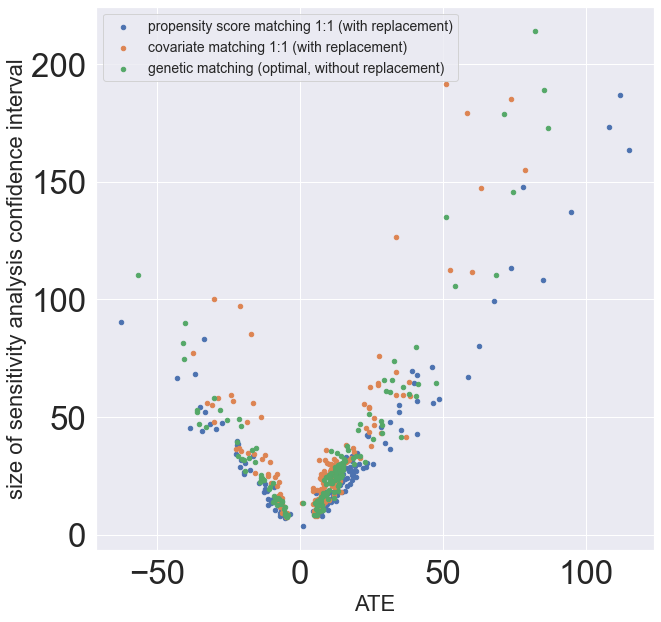

In [64]:
ate_sensitivity_tables = [ps_matching_sensitivity_ate_table_11,
                          cov_matching_sensitivity_ate_table_11,
                          genetic_sensitivity_ate_table]

plt.figure(figsize=(10,10))
for table,method in zip(ate_sensitivity_tables,[methods[1],methods[3],methods[5]]):
    gene_inds = [x for x in table1.index if (np.abs(table1.loc[x,'ate'])>=5 and np.abs(table1.loc[x,'ate'])<=100)]
    plt.scatter(table.loc[gene_inds,'ate'],(table.loc[gene_inds,'upper_bound']-table.loc[gene_inds,'lower_bound']),
               label=method, s=20)
    plt.xlabel('ATE', fontsize=22)
    plt.ylabel('size of sensitivity analysis confidence interval', fontsize=22)
    plt.legend(prop={'size': 14})

In [65]:
# Median of bootstrpping CI width for different methods
for method,table in zip(methods[:5],ate_tables[:5]):
    gene_inds = [x for x in table1.index if (table1.loc[x,'ate']>=5)]
    print(method, ':\t', (table.loc[gene_inds,'95_C.I._max']-table.loc[gene_inds,'95_C.I._min']).median())

IPW :	 78.0900384375731
propensity score matching 1:1 (with replacement) :	 18.511275075444686
propensity score matching 1:N (with replacement) :	 18.13154176637552
covariate matching 1:1 (with replacement) :	 19.291235751438805
covariate matching 1:N (with replacement) :	 18.349846734608022


In [66]:
# Median of sensitivity analysis CI width for different methods
for method,table in zip([methods[1],methods[3],methods[5]],ate_sensitivity_tables):
    gene_inds = [x for x in table1.index if (table1.loc[x,'ate']>=5)]
    print(method, ':\t', (table.loc[gene_inds,'upper_bound']-table.loc[gene_inds,'lower_bound']).median())

propensity score matching 1:1 (with replacement) :	 24.1004
covariate matching 1:1 (with replacement) :	 25.5004
genetic matching (optimal, without replacement) :	 25.099899999999998


In [67]:
##################################### Venn diagrams ####################################################

In [68]:
ate_thr = 5
final_genes = []

for t,table in enumerate(ate_tables+ate_sensitivity_tables[:2]):
    table = table[table.loc[:,'ate'].abs()>=ate_thr]
    if t<5:
        table = table[table['95_C.I._min']*table['95_C.I._max']>0]
    else:
        table = table[table['lower_bound']*table['upper_bound']>0]
    final_genes.append(set(table.index))
#final_genes  

C:\Users\hadas\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


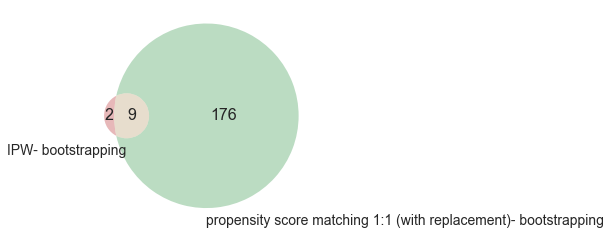

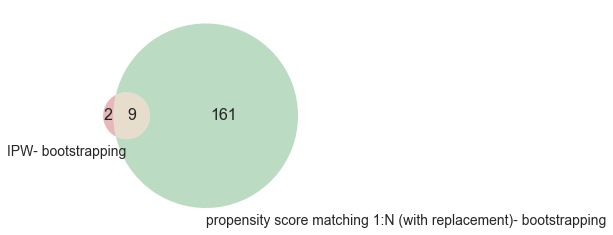

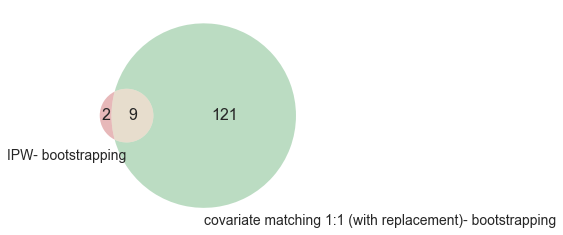

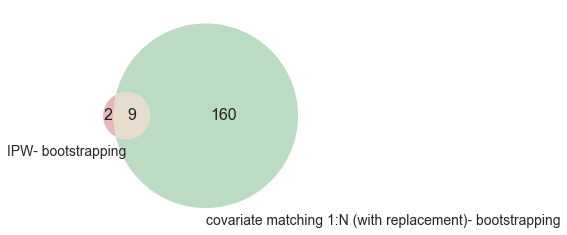

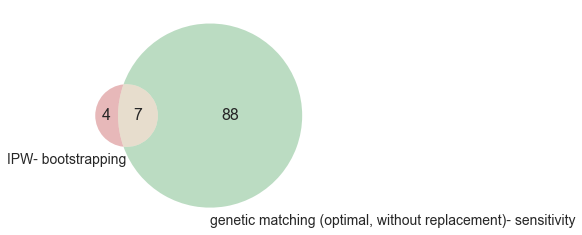

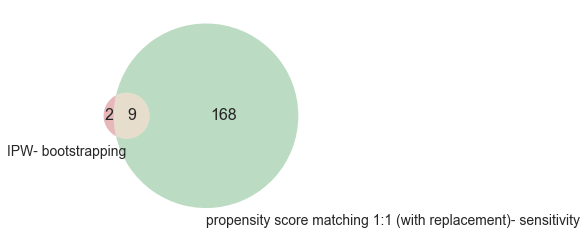

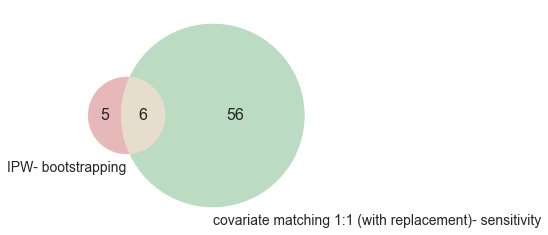

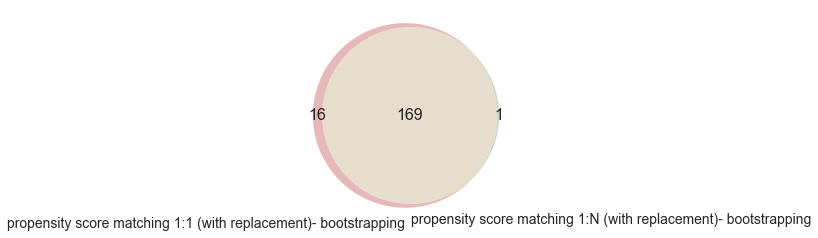

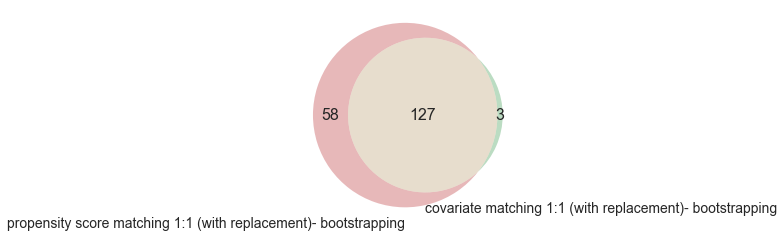

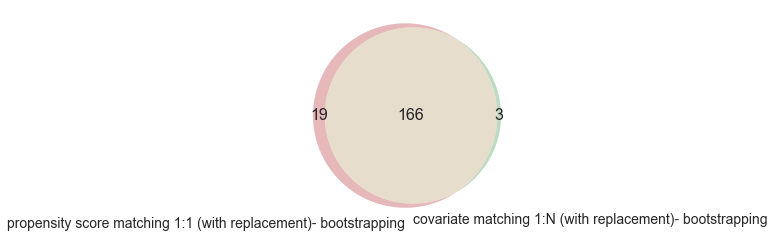

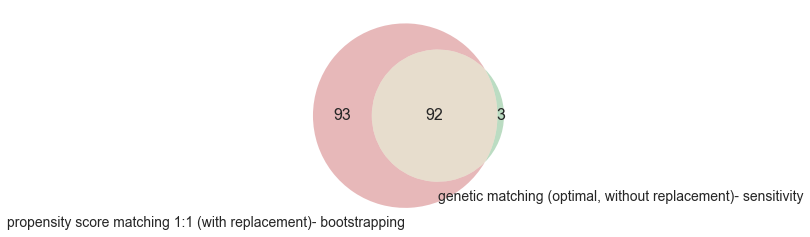

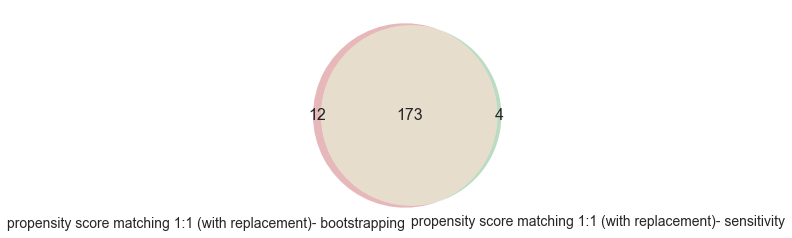

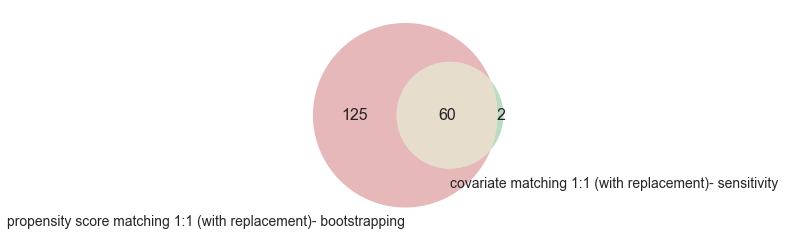

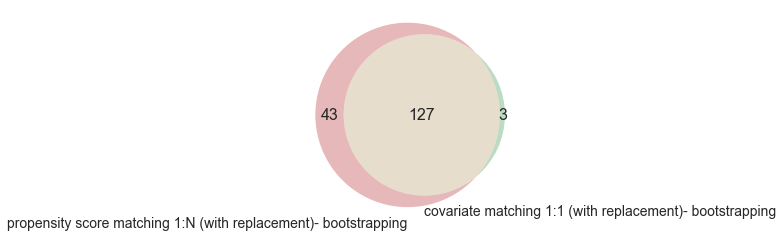

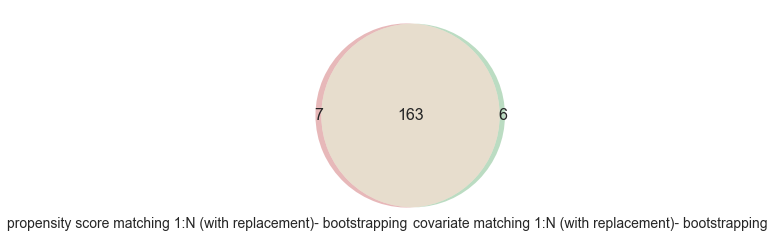

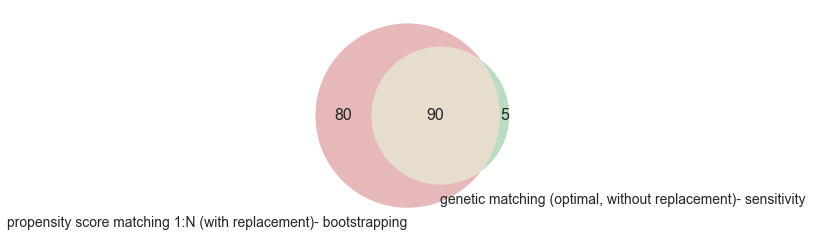

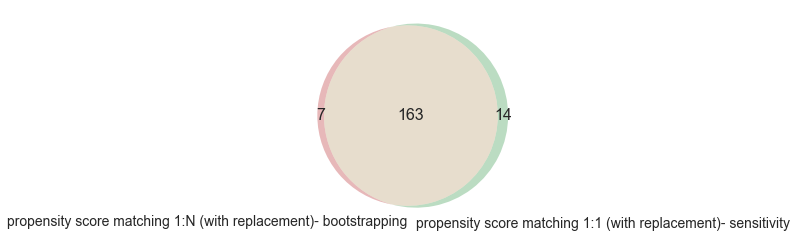

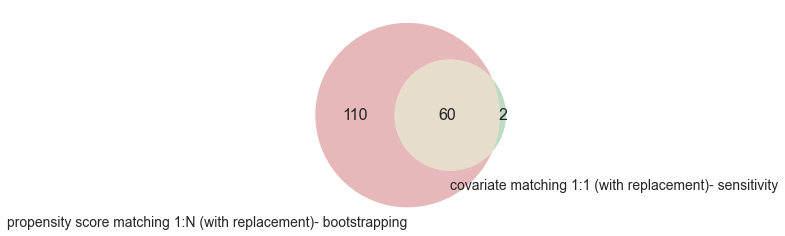

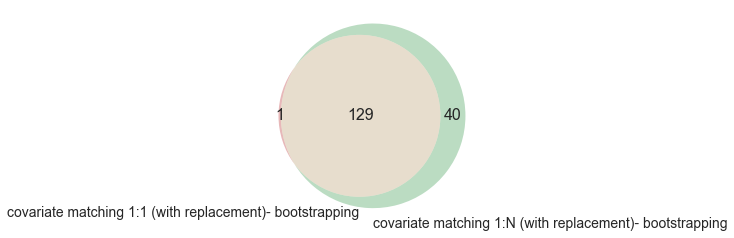

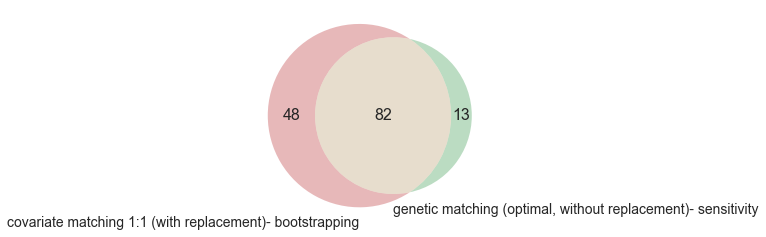

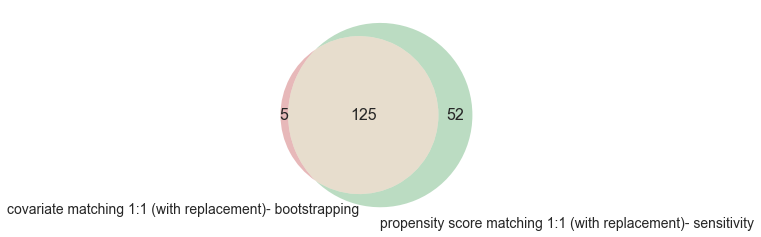

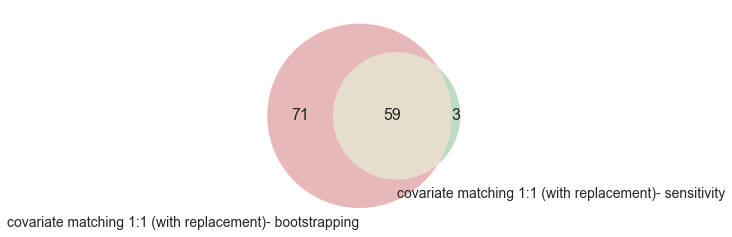

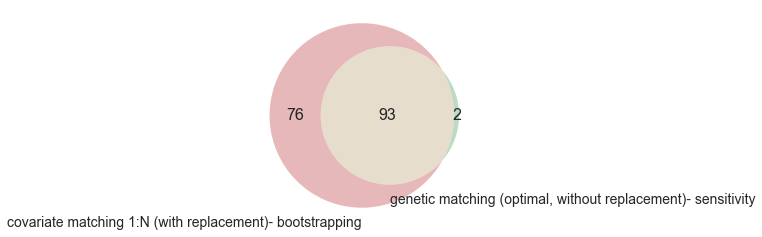

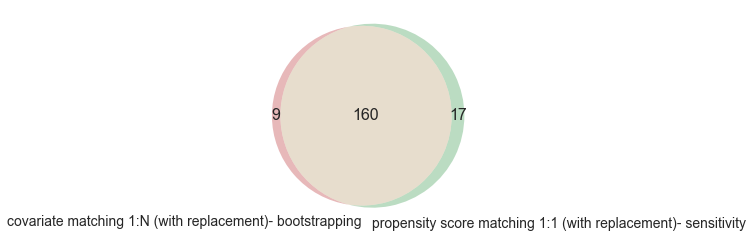

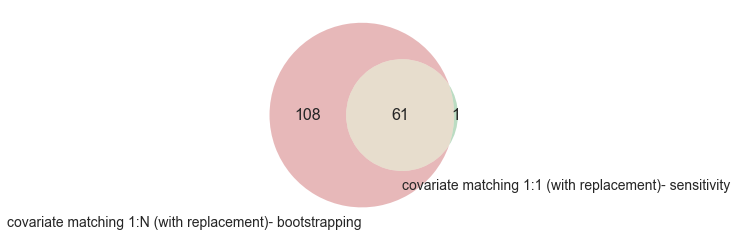

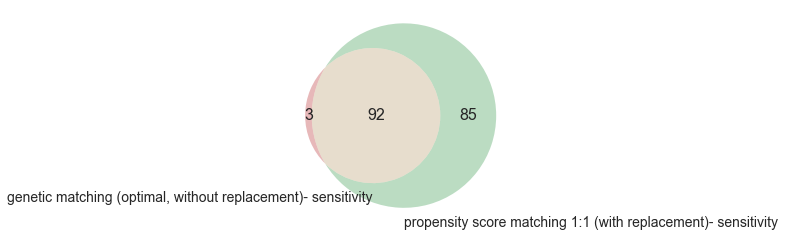

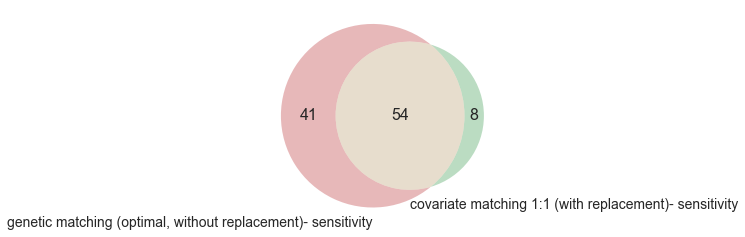

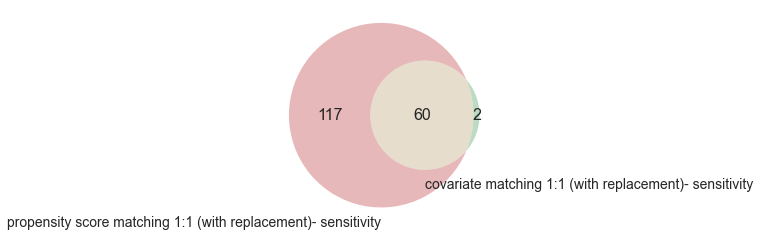

In [69]:
# venn2 diagrams of all method-pairs
methods_new = [x+'- bootstrapping' for x in methods[:5]]+[x+'- sensitivity' for x in [methods[5],methods[1],methods[3]]]
for i in range(len(methods_new)):
    for j in np.arange(i+1,len(methods_new)):
        ij = final_genes[i].intersection(final_genes[j])
        plt.figure()
        out = venn2(subsets = (len(final_genes[i]-ij), len(final_genes[j]-ij), len(ij)), set_labels = (methods_new[i], methods_new[j]))
        for text in out.set_labels:
            text.set_fontsize(14)
        for text in out.subset_labels:
            text.set_fontsize(16)

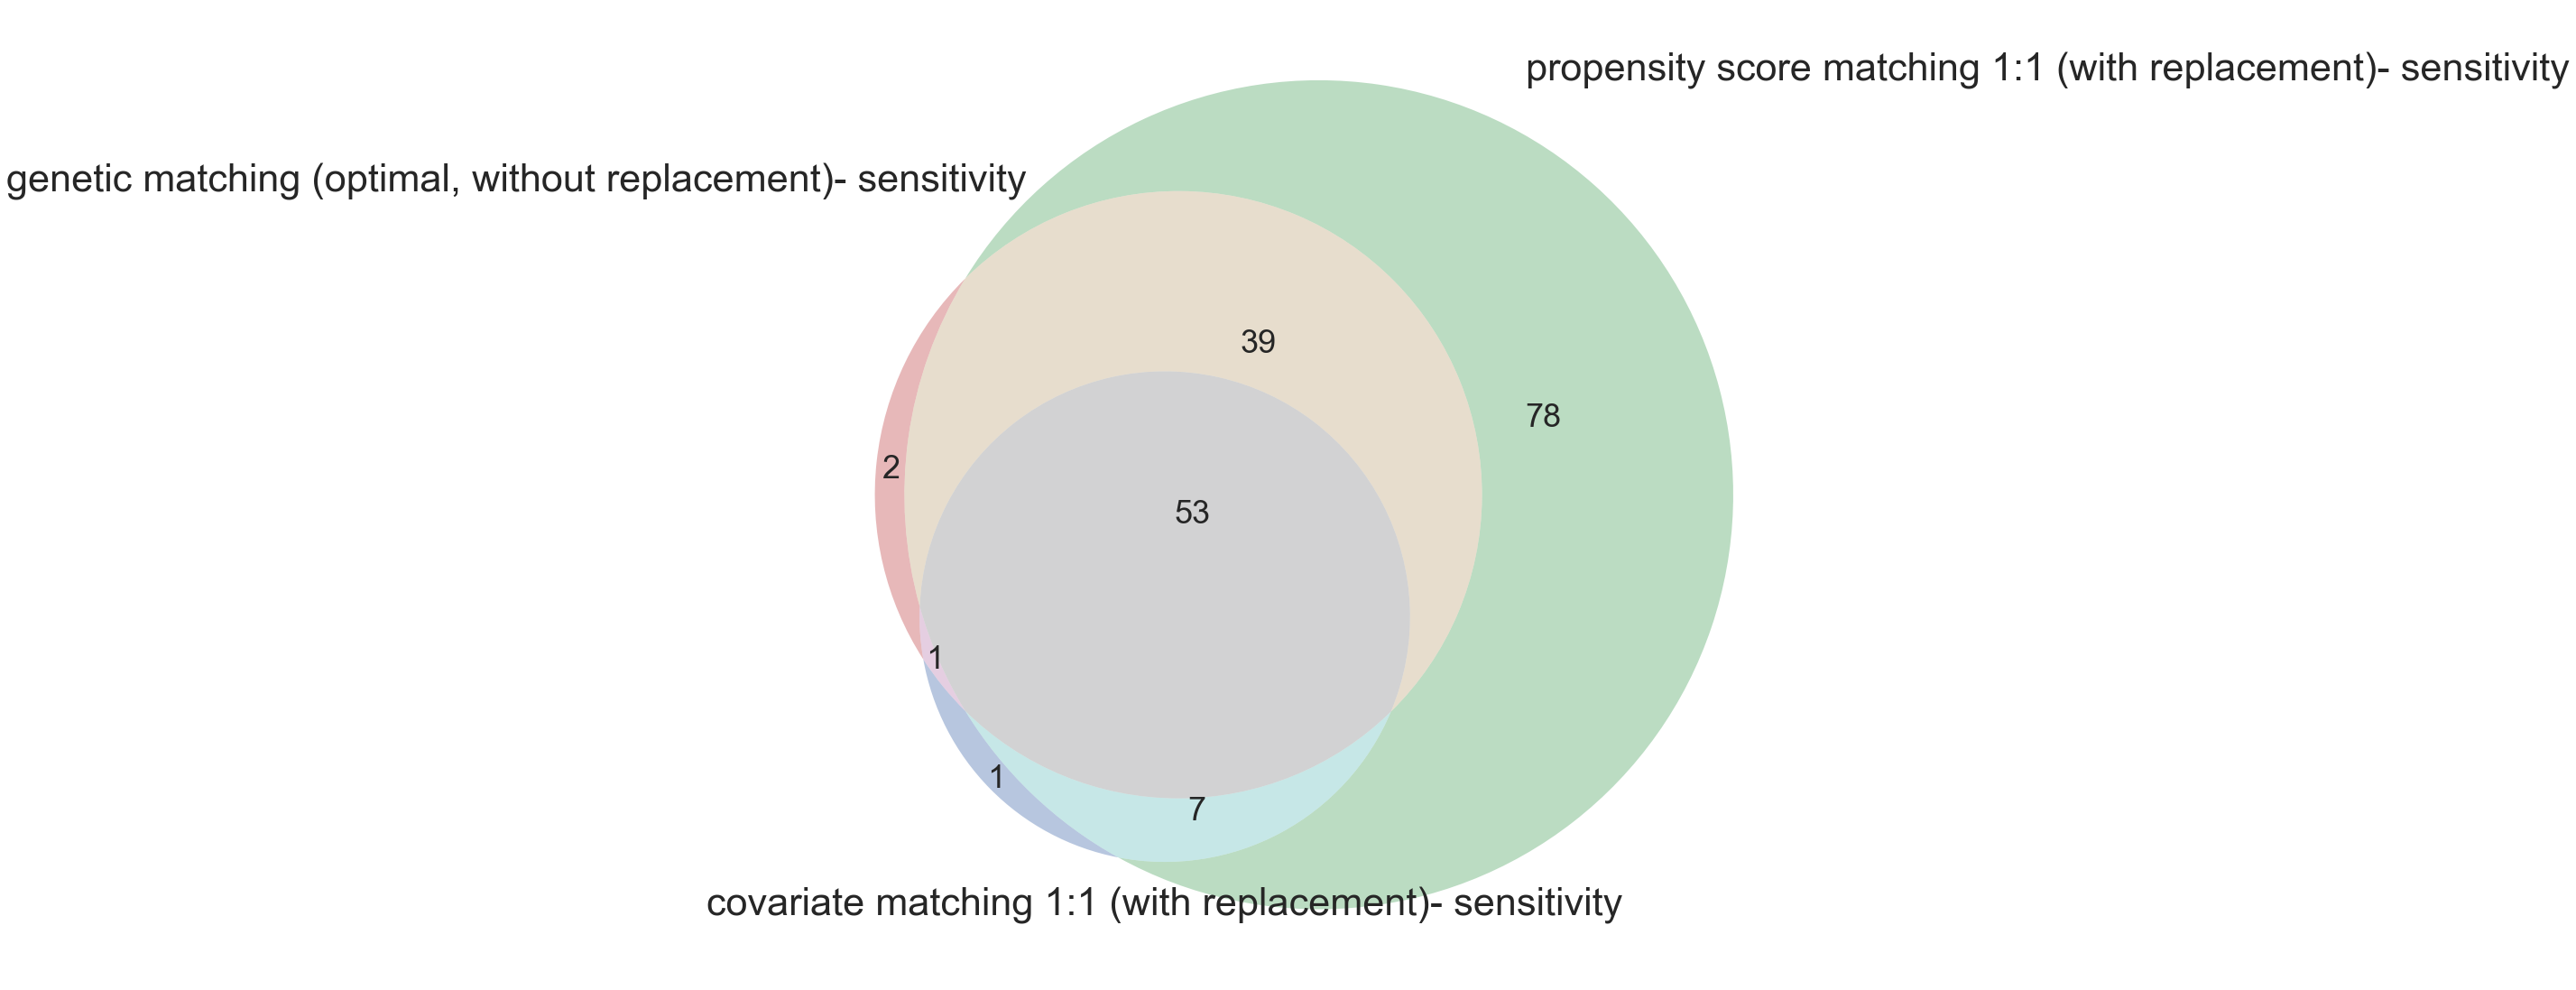

In [70]:
# venn3 diagram of the three 1:1 methods+ sensitivity CI
i = 5
j = 6
k = 7
ij = final_genes[i].intersection(final_genes[j])
ik = final_genes[i].intersection(final_genes[k])
jk = final_genes[k].intersection(final_genes[j])
ijk = final_genes[i].intersection(final_genes[j]).intersection(final_genes[k])
plt.figure(figsize=(20,20))
venn3(subsets = (len(final_genes[i]-ij-ik), 
                 len(final_genes[j]-ij-jk),
                 len(ij-ijk),
                 len(final_genes[k]-ik-jk),
                 len(ik-ijk),
                 len(jk-ijk),
                 len(ijk)), set_labels = (methods_new[i], methods_new[j], methods_new[k]))

In [71]:
for x in [i,j,k]:
    print(methods_new[x],':', len(final_genes[x]))

genetic matching (optimal, without replacement)- sensitivity : 95
propensity score matching 1:1 (with replacement)- sensitivity : 177
covariate matching 1:1 (with replacement)- sensitivity : 62
